In [ ]:
import torch, torchvision, json, os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving TestDataSet.zip to TestDataSet.zip


In [ ]:
!unzip -q TestDataSet.zip -d /content/


replace /content/__MACOSX/TestDataSet/._n02795169? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!ls /content/TestDataSet
!ls /content/TestDataSet/* | head -n 5


labels_list.json  n02782093  n02808304	n02865351  n02930766  n02988304
n02672831	  n02783161  n02808440	n02869837  n02939185  n02992211
n02676566	  n02786058  n02814533	n02870880  n02948072  n02992529
n02687172	  n02787622  n02814860	n02871525  n02950826  n02999410
n02690373	  n02788148  n02815834	n02877765  n02951358  n03000134
n02692877	  n02790996  n02817516	n02879718  n02951585  n03000247
n02699494	  n02791124  n02823428	n02883205  n02963159  n03000684
n02701002	  n02791270  n02823750	n02892201  n02965783  n03014705
n02704792	  n02793495  n02825657	n02892767  n02966193  n03016953
n02708093	  n02794156  n02834397	n02894605  n02966687  n03017168
n02727426	  n02795169  n02835271	n02895154  n02971356  n03018349
n02730930	  n02797295  n02837789	n02906734  n02974003  n03026506
n02747177	  n02799071  n02840245	n02909870  n02977058  n03028079
n02749479	  n02802426  n02841315	n02910353  n02978881  n03032252
n02769748	  n02804414  n02843684	n02916936  n02979186  n03041632
n02776631	  n028046

In [ ]:
# Task 1
model = models.resnet34(weights='IMAGENET1K_V1').to(device).eval()

# ImageNet preprocessing
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
plain_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Label index map
root_dir = "/content/TestDataSet"
class_folders = sorted([d for d in os.listdir(root_dir) if d.startswith("n")])
folder_to_label = {folder: 401 + i for i, folder in enumerate(class_folders)}

# Load image paths
image_paths = glob.glob(f"{root_dir}/n*/**/*.JPEG", recursive=True)

# Top-k evaluation
top1, top5, total = 0, 0, 0

for path in tqdm(image_paths, desc="Evaluating ResNet-34"):
    img = Image.open(path).convert("RGB")
    input_tensor = plain_transforms(img).unsqueeze(0).to(device)
    output = model(input_tensor)

    pred_top5 = torch.topk(output, k=5, dim=1).indices[0].cpu().numpy()

    # Get true label from folder name
    folder = os.path.basename(os.path.dirname(path))
    true_label = folder_to_label[folder]

    if pred_top5[0] == true_label:
        top1 += 1
    if true_label in pred_top5:
        top5 += 1
    total += 1

# Accuracy results
print(f"\nTop-1 Accuracy: {100 * top1 / total:.2f}%")
print(f"Top-5 Accuracy: {100 * top5 / total:.2f}%")

Evaluating ResNet-34: 100%|██████████| 500/500 [00:03<00:00, 127.93it/s]


Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


In [ ]:
# Task 2: FGSM in Raw Pixel Space (ε = 0.02, Correct Gradient Application)
eps = 0.02
loss_fn = torch.nn.CrossEntropyLoss()
adv_dir = "/content/AdversarialTestSet1"
os.makedirs(adv_dir, exist_ok=True)

top1_adv, top5_adv, total = 0, 0, 0

for path in tqdm(image_paths, desc="Running FGSM attack"):
    # Load and preprocess
    img = Image.open(path).convert("RGB")
    x_raw = transforms.ToTensor()(img).unsqueeze(0).to(device)
    x_raw.requires_grad = True

    # Normalize for model input
    mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(device)
    std = torch.tensor(std_norms).view(1, 3, 1, 1).to(device)
    x_norm = (x_raw - mean) / std

    # Get label
    folder = os.path.basename(os.path.dirname(path))
    label = torch.tensor([folder_to_label[folder]], device=device)

    # Forward and backward
    output = model(x_norm)
    loss = loss_fn(output, label)
    model.zero_grad()
    loss.backward()

    # Chain rule: gradient wrt raw image
    grad_raw = x_raw.grad / std

    # FGSM step in raw space
    x_adv = x_raw + eps * grad_raw.sign()
    x_adv = x_adv.clamp(0, 1).detach()

    # Check L∞
    linf = (x_adv - x_raw).abs().max().item()
    assert linf <= eps + 1e-5, f"eps constraint violated: got {linf:.5f}"

    # Evaluate
    x_adv_norm = (x_adv - mean) / std
    with torch.no_grad():
        out_adv = model(x_adv_norm)
        top5_preds = out_adv.topk(5, dim=1).indices[0].cpu().numpy()
        true = label.item()
        if top5_preds[0] == true:
            top1_adv += 1
        if true in top5_preds:
            top5_adv += 1
        total += 1

    # Save adversarial image
    filename = os.path.basename(path)
    save_image(x_adv.cpu().squeeze(), os.path.join(adv_dir, filename))

# Print results
print(f"\nTask 2 Results (FGSM eps = {eps}):")
print(f"Evaluated: {total} samples")
print(f"Top-1 Accuracy: {100 * top1_adv / total:.2f}%")
print(f"Top-5 Accuracy: {100 * top5_adv / total:.2f}%")


Running FGSM attack: 100%|██████████| 500/500 [00:11<00:00, 43.78it/s]


Task 2 Results (FGSM eps = 0.02):
Evaluated: 500 samples
Top-1 Accuracy: 3.60%
Top-5 Accuracy: 20.80%


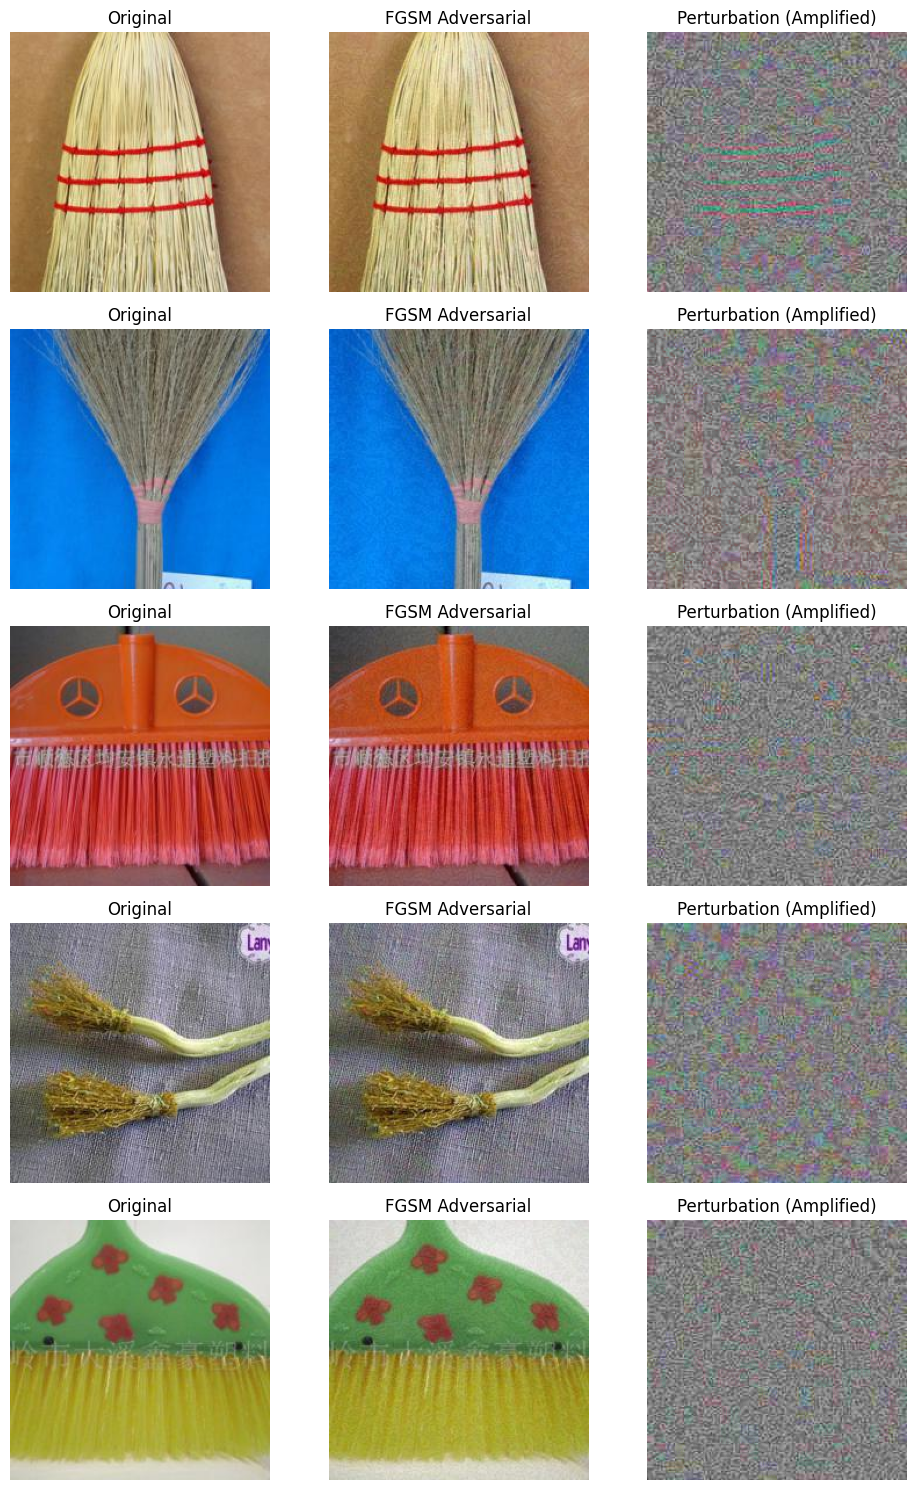

In [ ]:
def visualize_fgsm_examples(image_paths, adv_dir, count=5):
    fig, axs = plt.subplots(count, 3, figsize=(10, 3 * count))
    for i, path in enumerate(image_paths[:count]):
        orig = Image.open(path).convert("RGB").resize((224, 224))
        adv_path = os.path.join(adv_dir, os.path.basename(path))
        adv = Image.open(adv_path).convert("RGB").resize((224, 224))

        orig_np = np.asarray(orig).astype(np.float32) / 255
        adv_np = np.asarray(adv).astype(np.float32) / 255
        diff = np.clip((adv_np - orig_np) * 5 + 0.5, 0, 1)  # amplify

        axs[i, 0].imshow(orig)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(adv)
        axs[i, 1].set_title("FGSM Adversarial")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(diff)
        axs[i, 2].set_title("Perturbation (Amplified)")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_fgsm_examples(image_paths, "/content/AdversarialTestSet1")


In [ ]:
# Task 3: PGD Attack in Raw Pixel Space (ε = 0.02)
eps = 0.02
alpha = 0.005  # Step size
steps = 10
adv_dir_pgd = "/content/AdversarialTestSet2"
os.makedirs(adv_dir_pgd, exist_ok=True)

top1_pgd, top5_pgd, total = 0, 0, 0

for path in tqdm(image_paths, desc="Running PGD attack"):
    img = Image.open(path).convert("RGB")
    x_raw = transforms.ToTensor()(img).unsqueeze(0).to(device)
    x_orig = x_raw.clone()
    x_adv = x_raw.clone().detach().requires_grad_(True)

    # Label
    folder = os.path.basename(os.path.dirname(path))
    label = torch.tensor([folder_to_label[folder]], device=device)

    # Precompute mean and std tensors
    mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(device)
    std = torch.tensor(std_norms).view(1, 3, 1, 1).to(device)

    for _ in range(steps):
        x_norm = (x_adv - mean) / std
        output = model(x_norm)
        loss = loss_fn(output, label)
        model.zero_grad()
        loss.backward()

        # Chain rule to get gradient wrt raw space
        grad_raw = x_adv.grad / std

        # PGD step
        x_adv = x_adv + alpha * grad_raw.sign()
        x_adv = torch.max(torch.min(x_adv, x_orig + eps), x_orig - eps)  # Project to ε-ball
        x_adv = x_adv.clamp(0, 1).detach().requires_grad_(True)

    # L∞ check
    linf = (x_adv - x_orig).abs().max().item()
    assert linf <= eps + 1e-5, f"L constraint violated: {linf:.5f}"

    # Evaluate
    x_adv_norm = (x_adv - mean) / std
    with torch.no_grad():
        out = model(x_adv_norm)
        top5_preds = out.topk(5, dim=1).indices[0].cpu().numpy()
        true = label.item()
        if top5_preds[0] == true:
            top1_pgd += 1
        if true in top5_preds:
            top5_pgd += 1
        total += 1

    # Save image
    filename = os.path.basename(path)
    save_image(x_adv.cpu().squeeze(), os.path.join(adv_dir_pgd, filename))

# Final PGD results
print(f"\nTask 3 (PGD eps={eps}, alpha={alpha}, steps={steps})")
print(f"Evaluated: {total} samples")
print(f"Top-1 Accuracy: {100 * top1_pgd / total:.2f}%")
print(f"Top-5 Accuracy: {100 * top5_pgd / total:.2f}%")


Running PGD attack: 100%|██████████| 500/500 [01:12<00:00,  6.90it/s]


Task 3 (PGD eps=0.02, alpha=0.005, steps=10)
Evaluated: 500 samples
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 1.20%


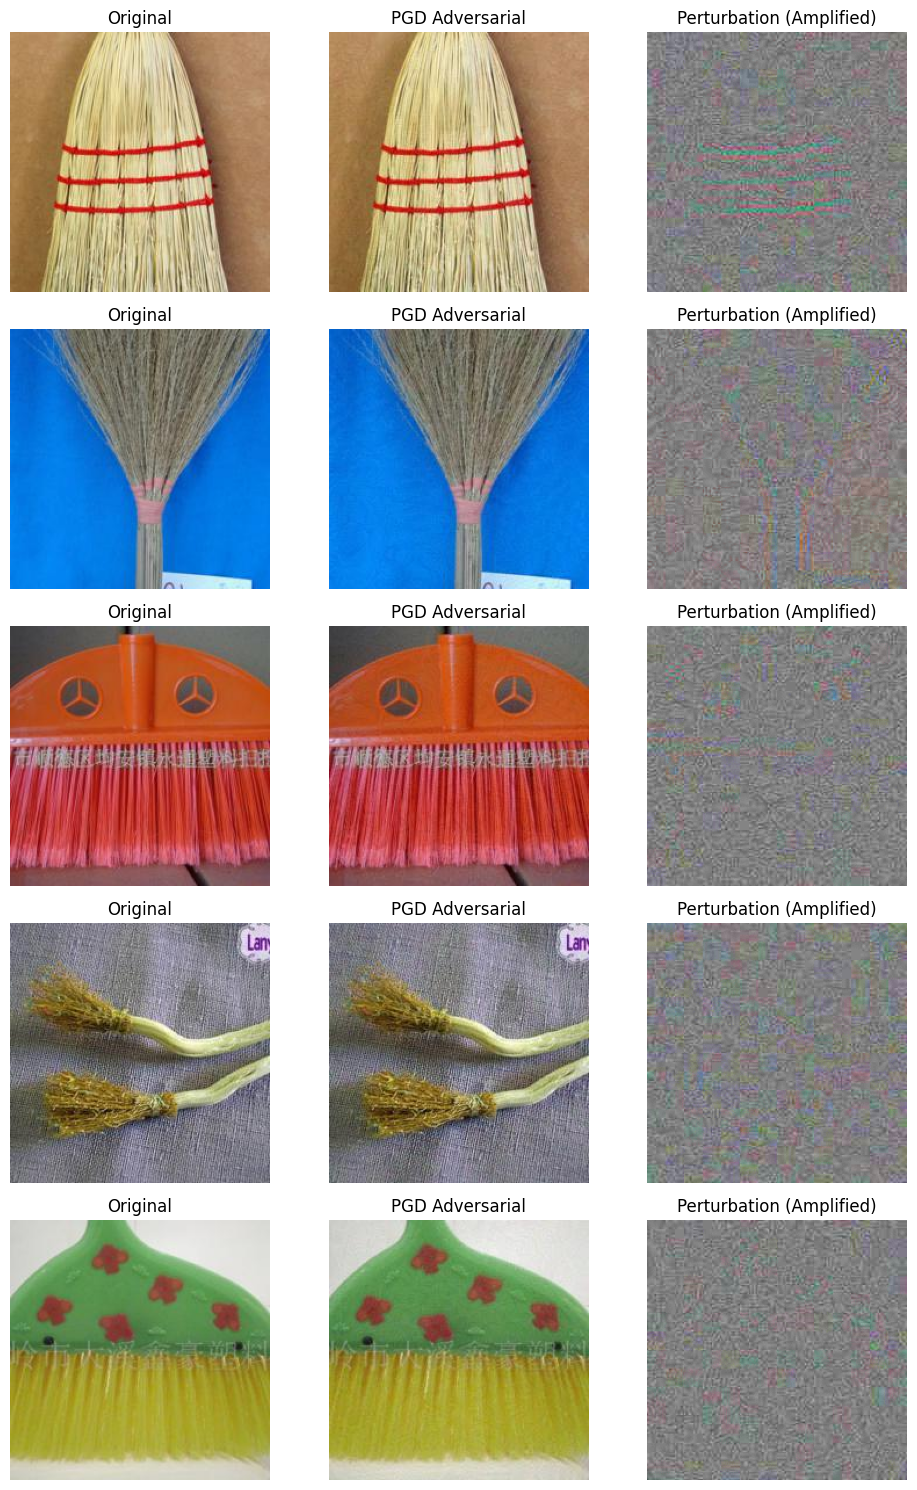

In [ ]:
def visualize_pgd_examples(image_paths, adv_dir, count=5):
    fig, axs = plt.subplots(count, 3, figsize=(10, 3 * count))
    for i, path in enumerate(image_paths[:count]):
        orig = Image.open(path).convert("RGB").resize((224, 224))
        adv_path = os.path.join(adv_dir, os.path.basename(path))
        adv = Image.open(adv_path).convert("RGB").resize((224, 224))

        orig_np = np.asarray(orig).astype(np.float32) / 255
        adv_np = np.asarray(adv).astype(np.float32) / 255
        diff = np.clip((adv_np - orig_np) * 5 + 0.5, 0, 1)

        axs[i, 0].imshow(orig)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(adv)
        axs[i, 1].set_title("PGD Adversarial")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(diff)
        axs[i, 2].set_title("Perturbation (Amplified)")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_pgd_examples(image_paths, "/content/AdversarialTestSet2")


In [ ]:
# Task 4: Patch-Based PGD Attack
eps_patch = 0.5
alpha_patch = 0.05
steps_patch = 10
patch_size = 32

adv_dir_patch = "/content/AdversarialTestSet3"
os.makedirs(adv_dir_patch, exist_ok=True)

top1_patch, top5_patch, total = 0, 0, 0

for path in tqdm(image_paths, desc="Running Patch PGD attack"):
    img = Image.open(path).convert("RGB")
    x_raw = transforms.ToTensor()(img).unsqueeze(0).to(device)
    x_orig = x_raw.clone()
    x_adv = x_raw.clone().detach().requires_grad_(True)

    # Choose random patch location
    _, _, H, W = x_raw.shape
    top = torch.randint(0, H - patch_size + 1, (1,)).item()
    left = torch.randint(0, W - patch_size + 1, (1,)).item()
    patch_slice = (slice(None), slice(None), slice(top, top + patch_size), slice(left, left + patch_size))

    # Get label
    folder = os.path.basename(os.path.dirname(path))
    label = torch.tensor([folder_to_label[folder]], device=device)

    # Mean and std for normalization
    mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(device)
    std = torch.tensor(std_norms).view(1, 3, 1, 1).to(device)

    for _ in range(steps_patch):
        x_norm = (x_adv - mean) / std
        output = model(x_norm)
        loss = loss_fn(output, label)
        model.zero_grad()
        loss.backward()

        grad_raw = x_adv.grad / std  # Chain rule
        # Apply gradient
        perturb = alpha_patch * grad_raw.sign()
        x_adv.data[patch_slice] += perturb[patch_slice]
        x_adv.data = torch.max(torch.min(x_adv, x_orig + eps_patch), x_orig - eps_patch)
        x_adv.data = x_adv.clamp(0, 1)
        x_adv.grad.zero_()

    # Evaluate
    x_adv_norm = (x_adv - mean) / std
    with torch.no_grad():
        out = model(x_adv_norm)
        top5_preds = out.topk(5, dim=1).indices[0].cpu().numpy()
        true = label.item()
        if top5_preds[0] == true:
            top1_patch += 1
        if true in top5_preds:
            top5_patch += 1
        total += 1

    # Save image
    filename = os.path.basename(path)
    save_image(x_adv.cpu().squeeze(), os.path.join(adv_dir_patch, filename))

# Print results
print(f"\nTask 4 Results:")
print(f"Evaluated: {total} samples")
print(f"Top-1 Accuracy: {100 * top1_patch / total:.2f}%")
print(f"Top-5 Accuracy: {100 * top5_patch / total:.2f}%")


Running Patch PGD attack: 100%|██████████| 500/500 [01:13<00:00,  6.81it/s]


Task 4 Results:
Evaluated: 500 samples
Top-1 Accuracy: 30.20%
Top-5 Accuracy: 67.60%


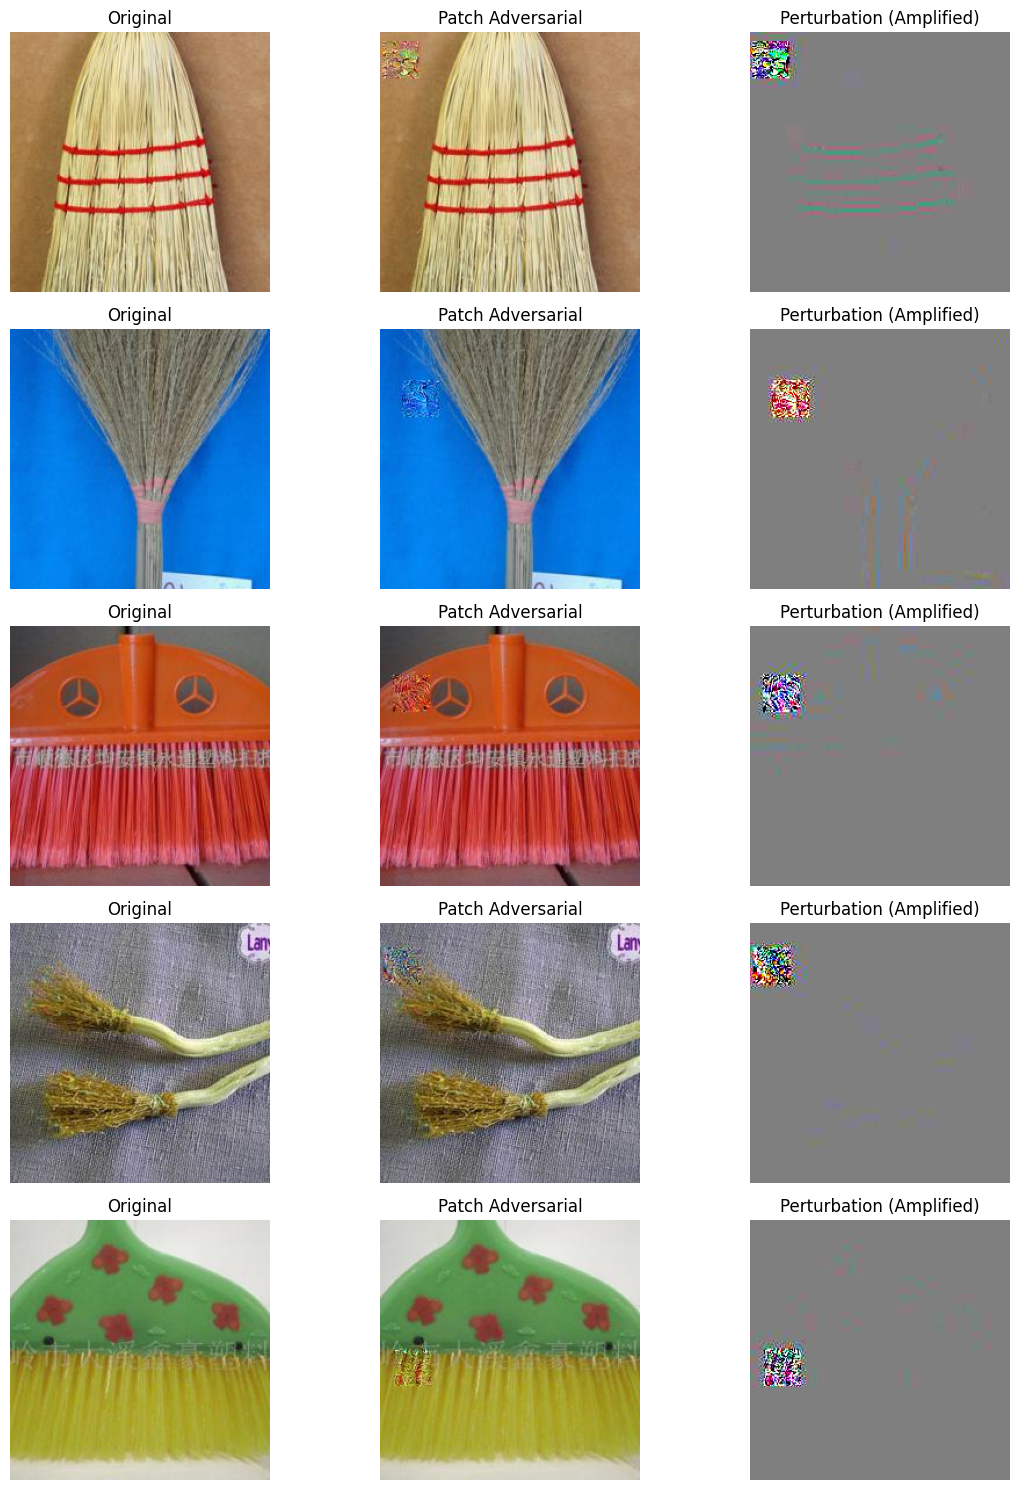

In [ ]:
def visualize_patch_examples_simple(image_paths, adv_dir, count=5):
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image

    fig, axs = plt.subplots(count, 3, figsize=(12, 3 * count))

    for i, path in enumerate(image_paths[:count]):
        # Load and resize
        orig = Image.open(path).convert("RGB").resize((224, 224))
        adv_path = os.path.join(adv_dir, os.path.basename(path))
        adv = Image.open(adv_path).convert("RGB").resize((224, 224))

        # Convert to [0,1] float numpy arrays
        orig_np = np.asarray(orig).astype(np.float32) / 255
        adv_np = np.asarray(adv).astype(np.float32) / 255

        # Compute difference
        diff = np.clip((adv_np - orig_np) * 5 + 0.5, 0, 1)  # amplify

        # Display all 3 images
        axs[i, 0].imshow(orig)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(adv)
        axs[i, 1].set_title("Patch Adversarial")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(diff)
        axs[i, 2].set_title("Perturbation (Amplified)")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Run it
visualize_patch_examples_simple(image_paths, "/content/AdversarialTestSet3", count=5)


In [ ]:
# Task 5: Transferability Evaluation using DenseNet-121
from torchvision import models
from PIL import Image

# Load DenseNet-121
densenet = models.densenet121(weights='IMAGENET1K_V1').to(device).eval()

# Define dataset paths
datasets = {
    "Original": image_paths,
    "FGSM": [os.path.join("/content/AdversarialTestSet1", os.path.basename(p)) for p in image_paths],
    "PGD": [os.path.join("/content/AdversarialTestSet2", os.path.basename(p)) for p in image_paths],
    "Patch": [os.path.join("/content/AdversarialTestSet3", os.path.basename(p)) for p in image_paths],
}

# Normalize constants
mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(device)
std = torch.tensor(std_norms).view(1, 3, 1, 1).to(device)

# Print header
print(f"{'Dataset':>10}  | {'Top-1 Accuracy':>15}  | {'Top-5 Accuracy':>15}")
print("-" * 48)

# Evaluate each dataset
for name, paths in datasets.items():
    top1, top5, total = 0, 0, 0
    for i, path in enumerate(paths):
        img = Image.open(path).convert("RGB")
        x = transforms.ToTensor()(img).unsqueeze(0).to(device)
        x = (x - mean) / std  # Apply ImageNet normalization

        # Get true label from original clean image path
        folder = os.path.basename(os.path.dirname(image_paths[i]))
        true_label = folder_to_label[folder]

        with torch.no_grad():
            output = densenet(x)
            preds = output.topk(5, dim=1).indices[0].cpu().numpy()

            if preds[0] == true_label:
                top1 += 1
            if true_label in preds:
                top5 += 1
            total += 1

    top1_acc = 100 * top1 / total
    top5_acc = 100 * top5 / total
    print(f"{name:>10}  | {top1_acc:15.2f}%  | {top5_acc:15.2f}%")


   Dataset  |  Top-1 Accuracy  |  Top-5 Accuracy
------------------------------------------------
  Original  |           74.60%  |           93.60%
      FGSM  |           51.20%  |           80.00%
       PGD  |           56.80%  |           85.40%
     Patch  |           70.00%  |           91.40%
